### Use this to create graphs from results generated by the adversarial search scripts.

In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from collections import defaultdict

import pickle
import plot_params

#### Define helper functions.

In [4]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        # Remove unused data.
        results = [{
            'search_results': x['search_results'], 
            'baseline_results': x['baseline_results'],
            'bins': x['bins'],
            'p_norm': x['p_norm'],
            'q_norm': x['q_norm'],
            'epsilon': x['epsilon']
        } for x in results]
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

In [5]:
def get_improvement(ast_results, bfs_results):
    assert ast_results['index'].equals(bfs_results['index'])
    assert ast_results['found'].equals(bfs_results['found'])
    
    # Get the expansion arrays.
    bfs_expansions = bfs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    
    # Obtain indexes that would sort the BFS expansions array.
    idxs = np.argsort(bfs_expansions.values)
    
    # Use indexes to sort BFS and A* expansions arrays and compute improvement. 
    bfs_expansions_sorted = bfs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    
    improvement = ((bfs_expansions_sorted - ast_expansions_sorted) / ast_expansions_sorted) * 100
    return improvement, ast_expansions_sorted, bfs_expansions_sorted

In [6]:
def plot_comparison(bfs_sort, ast_sorts):
    # Display the "A* search vs BFS search" plot with different epsilons.
    plt.figure(figsize=(12,4))
    plt.plot(bfs_sort, color='blue', label='BFS')
    
    for epsilon, ast_sort in ast_sorts.items():    
        plt.plot(ast_sort, label='A* (epsilon = {})'.format(epsilon))
        
    plt.xlabel('Examples (sorted by BFS expansions)', fontsize=20)
    plt.ylabel('Expansions', fontsize=20)
    plt.legend(loc='best', fontsize=12)
    plt.title('A* Search vs BFS search')
    plt.show()
    
def plot_improvement(improvements):
    # Display the "A* over BFS search improvement" plot with different epsilons.
    plt.figure(figsize=(12,4))
    
    for epsilon, improvement in improvements.items():
        plt.plot(improvement, label='Epsilon = {}'.format(epsilon))
#         print('Average A* (eps = {}) improvement over BFS: {:.2f}%.'.format(epsilon, np.sum(improvement) / len(improvement)))
        
    plt.xlabel('Examples (sorted BFS expansions)', fontsize=20)
    plt.ylabel('Improvement (\%)', fontsize=20)
    plt.legend(loc='best', fontsize=12)
    plt.show()

#### Now we plot the required graphs.

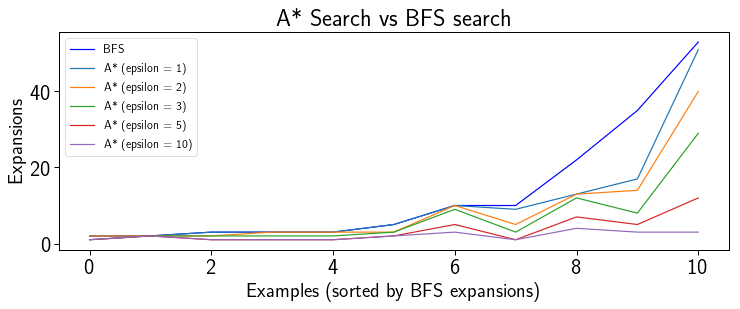

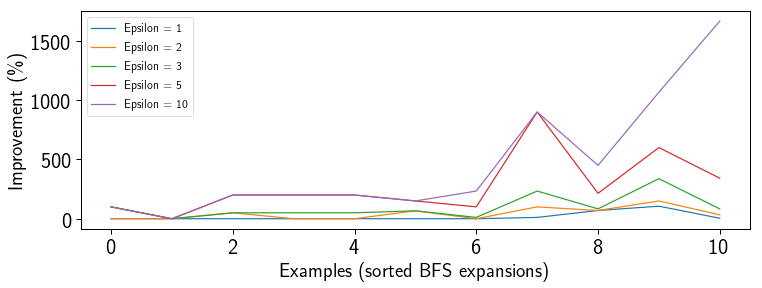

In [7]:
# Load results from running adversarial search on credit dataset.
results = load_results('../out/credit_3.pickle')

# Group the results by the required key.
results_by_key = group_by_key(results, 'epsilon')

# Pick the number of bins to examine (this can be computed in different ways).
bins = 45

# Get the required improvement data.
improvements, ast_sorts = {}, {}
for epsilon, items in results_by_key.items():
    
    for item in items:
        
        if item['bins'] != bins:
            continue
        
        ast_results, bfs_results = item['search_results'], item['baseline_results']
        improvement = get_improvement(ast_results=ast_results, bfs_results=bfs_results)
        
        improvements[epsilon] = improvement[0]
        ast_sorts[epsilon] = improvement[1]

        
bfs_sort = improvement[2] # changing epslion does not change bfs results

# Now plot the graphs.
plot_comparison(bfs_sort, ast_sorts)
plot_improvement(improvements)

#### This can be used to establish the best number of bins given different parameters.

In [8]:
# Load results from running adversarial search on credit dataset.
results = load_results('../out/credit_3.pickle')
results_by_key = group_by_key(results, 'epsilon')

for epsilon, items in results_by_key.items():
    
    improvements, binss = [], []
    for item in items:
        
        ast_results, bfs_results = item['search_results'], item['baseline_results']
        improvement = get_improvement(ast_results=ast_results, bfs_results=bfs_results)
    
        improvements.append(improvement)
        binss.append(item['bins'])
        
    arg_max = np.argmax([x[0].mean() for x in improvements])
    arg_max_bins = binss[arg_max]
    print('For epsilon: {} best number of bins is: {}.'.format(epsilon, arg_max_bins))    

For epsilon: 1 best number of bins is: 45.
For epsilon: 2 best number of bins is: 40.
For epsilon: 3 best number of bins is: 20.
For epsilon: 5 best number of bins is: 75.
For epsilon: 10 best number of bins is: 45.
